In [396]:
#!pip install pandas_profiling

In [496]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
%matplotlib inline

In [497]:
# Loading the data

In [498]:
loan = pd.read_csv('/Users/amisehga/dev/Upgrad/Lending/loan.csv')

In [499]:
# Shape of the data

In [500]:
loan.shape

(39717, 111)

##### Add a numerical column called status which is  0 Fully Paid and 1 Charged Off  

Text(0.5, 0, 'Count of defaulted and successful loans')

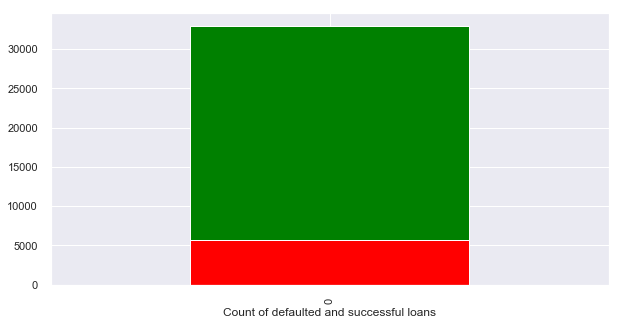

In [501]:
loan = loan.loc[loan.loan_status != 'Current']
#print(loan.groupby('loan_status')['loan_status'].count())
loan['status'] = loan['loan_status'].map(lambda x : 0 if (x == 'Fully Paid') else 1)
df = loan.groupby('loan_status')['loan_status'].count().rename('Frequency').reset_index()
df[df.loan_status=='Fully Paid']['Frequency'].plot.bar(stacked = True , figsize=(10,5),color='green')
df[df.loan_status!='Fully Paid']['Frequency'].plot.bar( figsize=(10,5),color='red')
plt.xlabel("Count of defaulted and successful loans")

### Checking the columns with more than 50% for the null values

In [502]:
limitPer = len(loan) * .50
loan = loan.dropna(thresh=limitPer,axis=1)
len(loan.columns)

55

In [503]:
# Checking the shape of the modified and reduced dataset df_1

In [504]:
loan.shape

(38577, 55)

### Remove constant value column and with less information variability

In [505]:
# Remove columns that just have constant values
loan = loan.loc[:,loan.apply(pd.Series.nunique) > 1]


In [506]:
loan['term_months'] = loan['term'].str.rstrip('months').replace(' ','').astype(int)
loan.drop(['term'], axis = 1, inplace = True)
loan['revol_util_percentage'] = loan['revol_util'].str.rstrip('%').replace(' ','').astype(float)
loan.drop(['revol_util'], axis = 1 , inplace = True)
loan['int_rate_modified'] = loan['int_rate'].str.rstrip('%').replace(' ','').astype(float)
loan.drop(['int_rate'] , axis = 1 , inplace = True)
df_1 = loan

In [507]:
df_1.shape

(38577, 44)

### Checking the correlation among the variables and removing least correlated vars < 5%

In [508]:
# corr = df_2.corr(method='spearman')
corr = df_1.corr()
cols = corr.columns
moreThan5Percent = corr.loc[(corr.status>0.05) | (corr.status < -0.05)]
corrData = moreThan5Percent['status'].reset_index()

print(corrData[corrData.status != 1].head())
correlatedCols = corrData['index']
#print(correlatedCols.to_list())
origCols = set(df_1.columns.to_list())
categoricals = (origCols - set( cols.to_list()))
mostCorrelatedColumns  = (list(categoricals) + correlatedCols.to_list())
print(len(mostCorrelatedColumns))
loan = df_1[mostCorrelatedColumns]
loan.shape

            index    status
0       loan_amnt  0.059463
1     funded_amnt  0.056497
2  inq_last_6mths  0.071878
3         pub_rec  0.051001
4     total_pymnt -0.235898
32


(38577, 32)

### Plot the correlation of the vars

Text(0.5, 1.0, 'Histogram of correlation to default status')

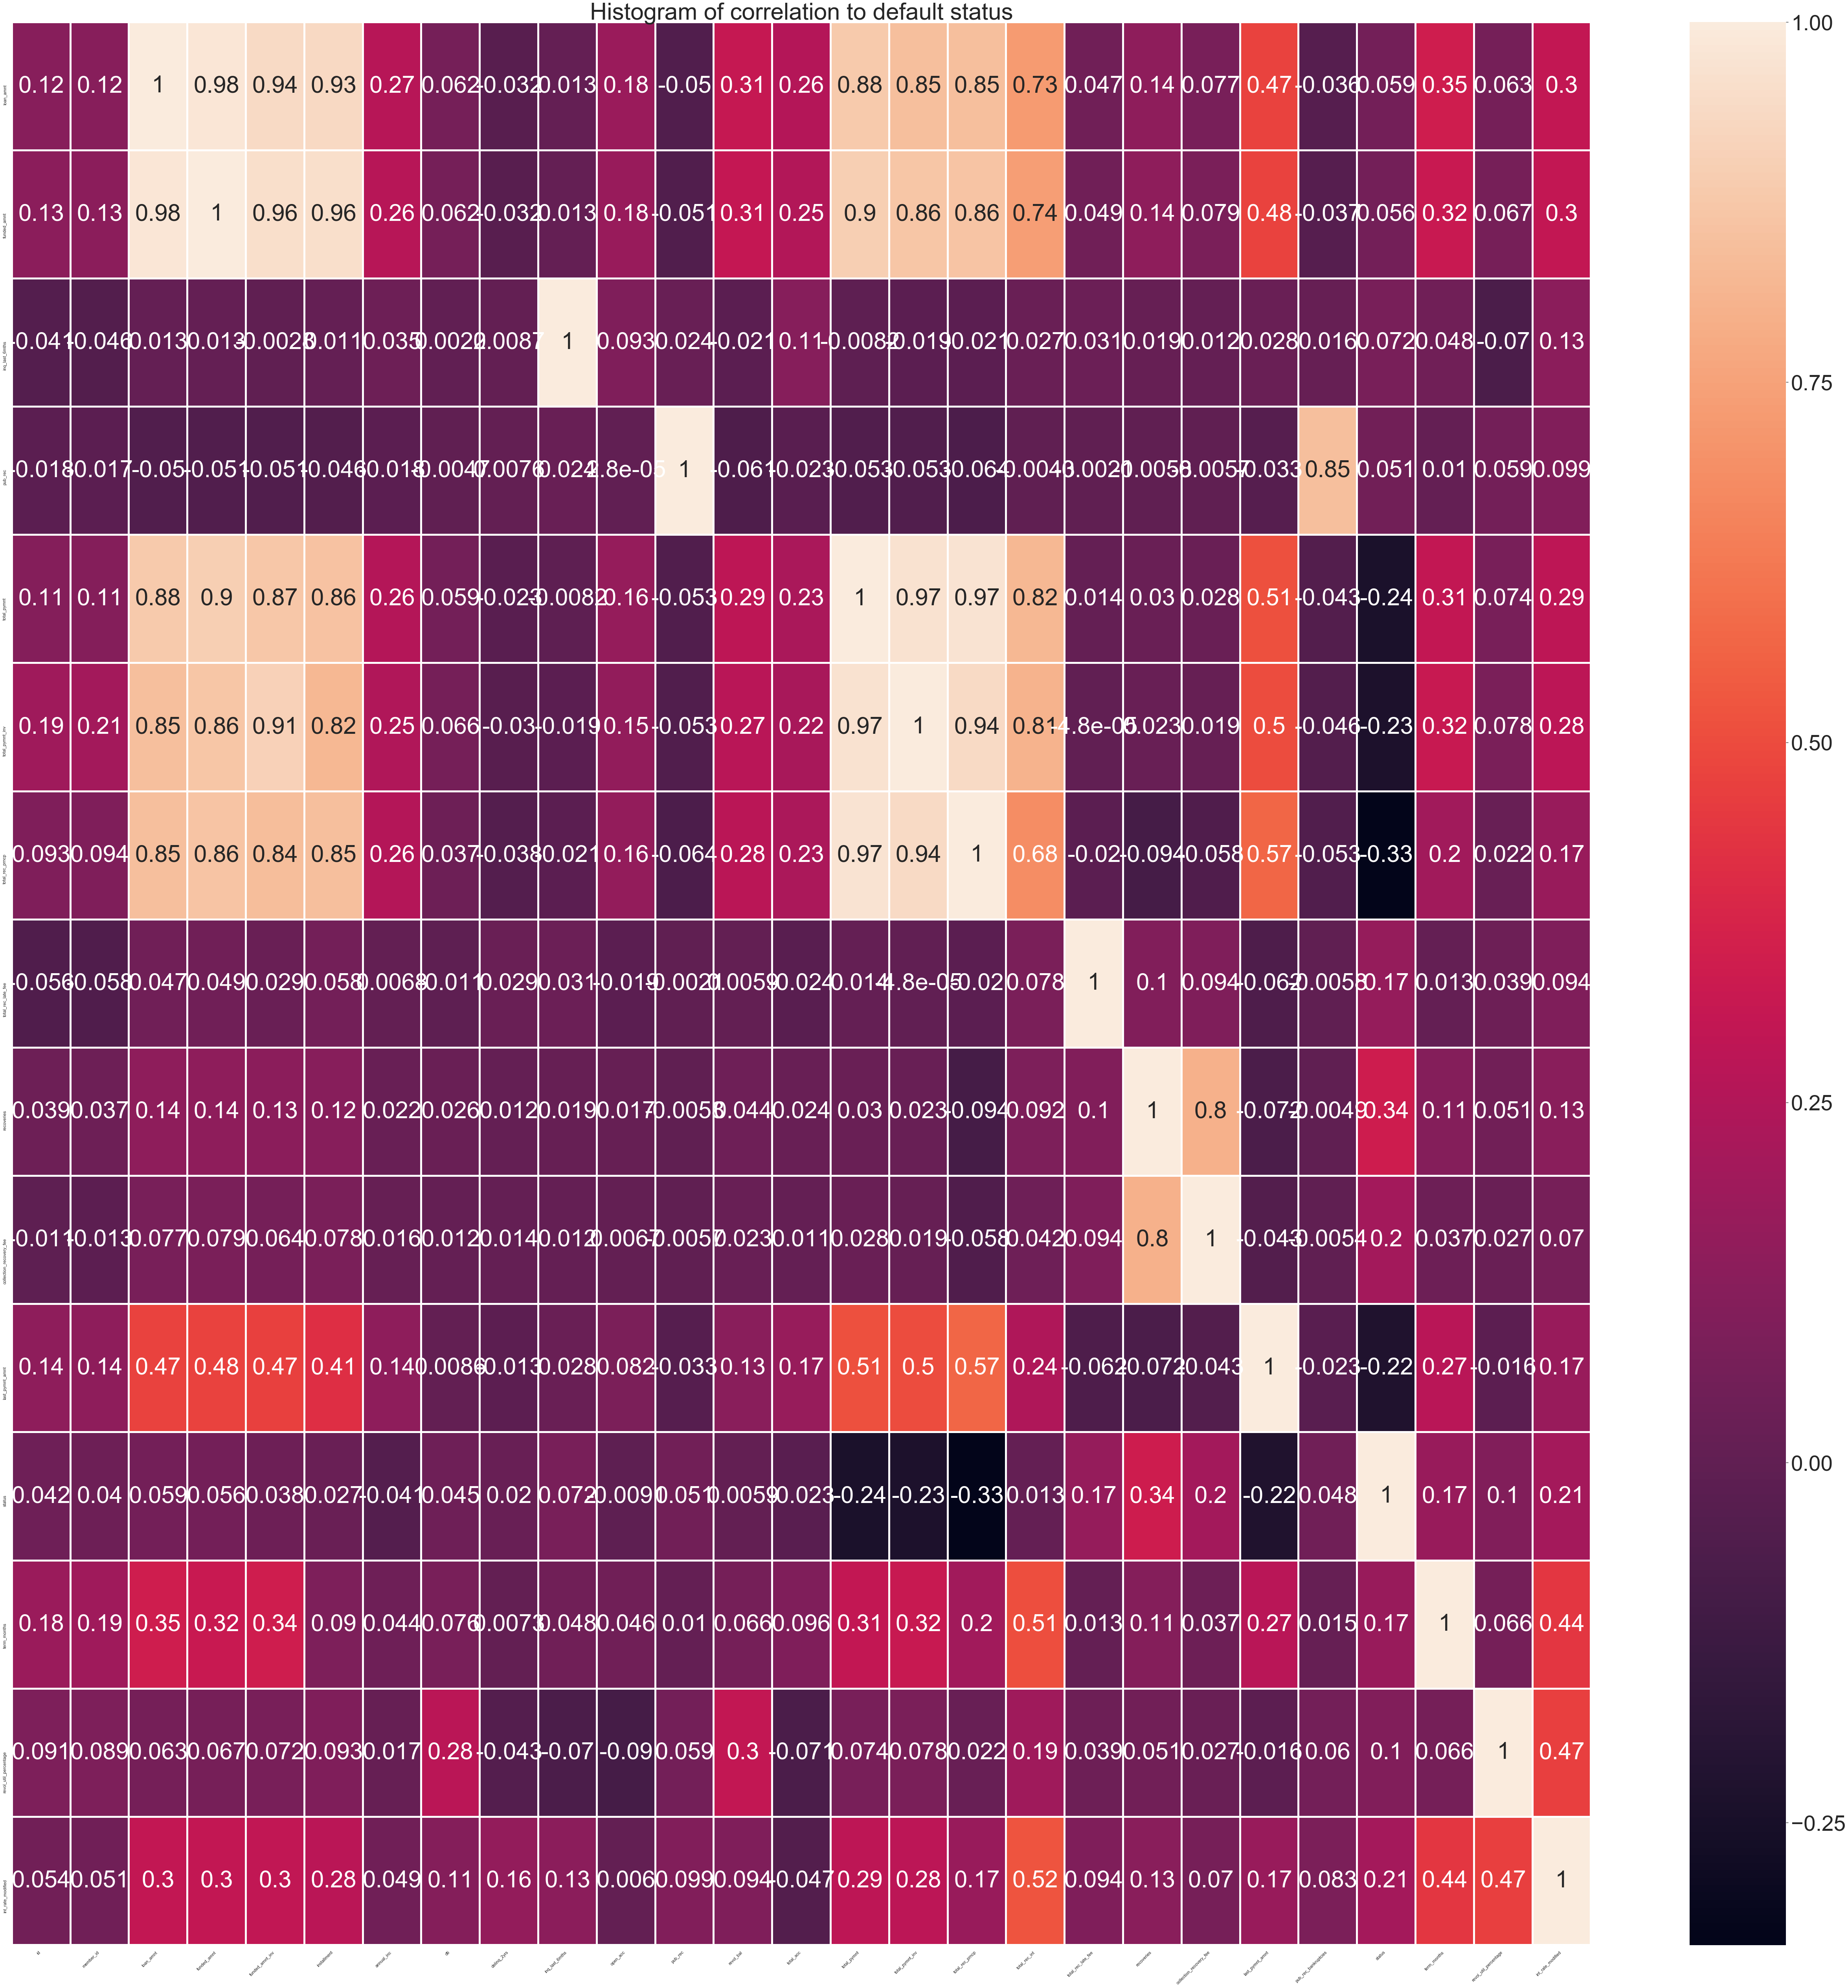

In [509]:
plt.subplots(figsize = (90,90))
sns.set(font_scale=5)
ax = sns.heatmap(moreThan5Percent , annot = True , linewidths = 4.0 )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.title("Histogram of correlation to default status")

#### This clearly states the amount of payment recieved till date is higher means the default is low
#### Below 11 columns are more correlated to loan status

Text(0.5, 1.0, 'How the features correlates to default status')

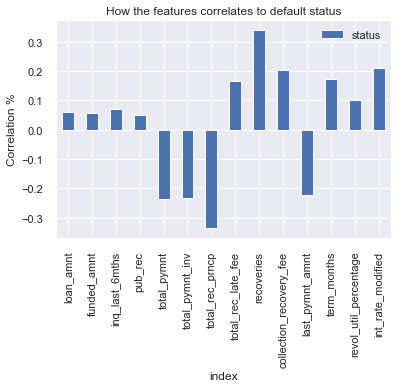

In [510]:
sns.set(font_scale=1.0)
corrData[corrData.status != 1].plot(kind='bar',x='index',y='status')
plt.xticks(rotation=90)
plt.ylabel("Correlation %")
plt.title("How the features correlates to default status")

##### Finding Ratio of Default by Grades of people

Text(30.971140277777778, 0.5, 'Ratio of Default')

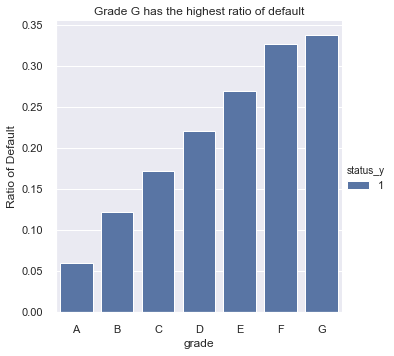

In [511]:
grouped0 = loan[loan.status == 0].groupby(['status','grade'])['loan_status'].count().rename('count').reset_index()
grouped1 = loan[loan.status == 1].groupby(['status','grade'])['loan_status'].count().rename('count').reset_index()
merged = pd.merge(grouped0,grouped1,on='grade')
merged['ratio'] = merged['count_y']/(merged['count_x']+merged['count_y'])
import seaborn as sns
sns.set()
sns.catplot(x='grade', y="ratio", hue="status_y",
            kind="bar", data=merged);
plt.title("Grade G has the highest ratio of default")
plt.ylabel("Ratio of Default")

#### This needs to be corrected

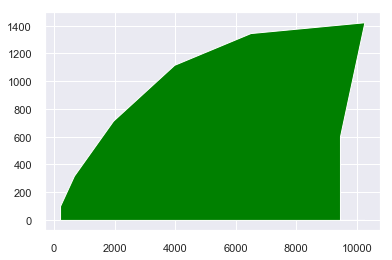

In [512]:
plt.stackplot(grouped0['count'], grouped1['count'], colors=['green','red'])

##### Let's bin the loan amount requested and then plot the default % against each bin

Text(0.5, 0, 'Loan Amount Requested Range ')

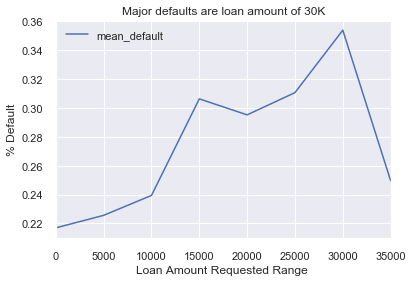

In [513]:
import numpy as np
gp1 = loan[loan.status == 1].groupby(['loan_amnt'])['loan_amnt'].count().rename('count').reset_index()
gp0 = loan[loan.status == 0].groupby(['loan_amnt'])['loan_amnt'].count().rename('count').reset_index()
merged = pd.merge(gp1,gp0,on='loan_amnt')
merged['ratio'] = merged['count_x']/(merged['count_x']+merged['count_y'])
merged = merged[['loan_amnt','ratio']]
##bins = np.linspace(min(merged['loan_amnt']),max(merged['loan_amnt']),10)
##merged['binned'] = pd.cut(merged['loan_amnt'],bins,include_lowest=True)
merged['bin'] = merged['loan_amnt'].map(lambda x : int(x/5000)*5000)
#print(merged.head())
gpp = merged.groupby(['bin'])['ratio'].mean().rename('mean_default').reset_index()
###histo = loan[loan.status == 1]['loan_amnt'].hist(bins=20)
import matplotlib.pyplot as plt

gpp.plot(x='bin',y='mean_default')
plt.title('Major defaults are loan amount of 30K')
plt.ylabel('% Default')
plt.xlabel('Loan Amount Requested Range ')

Text(0.5, 1.0, '60 months period has more defaults and purpose car has minimum default')

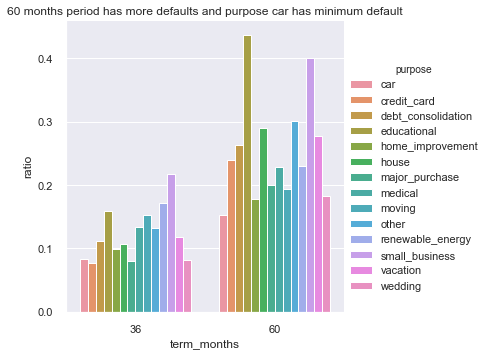

In [514]:
gp1 = loan[loan.status == 1].groupby(['term_months','purpose'])['term_months'].count().rename('count').reset_index()
gp0 = loan[loan.status == 0].groupby(['term_months','purpose'])['term_months'].count().rename('count').reset_index()

merged = pd.merge(gp1,gp0,on=['term_months','purpose'])
merged['ratio'] = merged['count_x']/(merged['count_x']+merged['count_y'])
merged = merged[['term_months','purpose','ratio']]
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.catplot(x='term_months', y="ratio", hue="purpose",
            kind="bar", data=merged)

plt.title('60 months period has more defaults and purpose car has minimum default')

Text(0, 0.5, 'Default_Count')

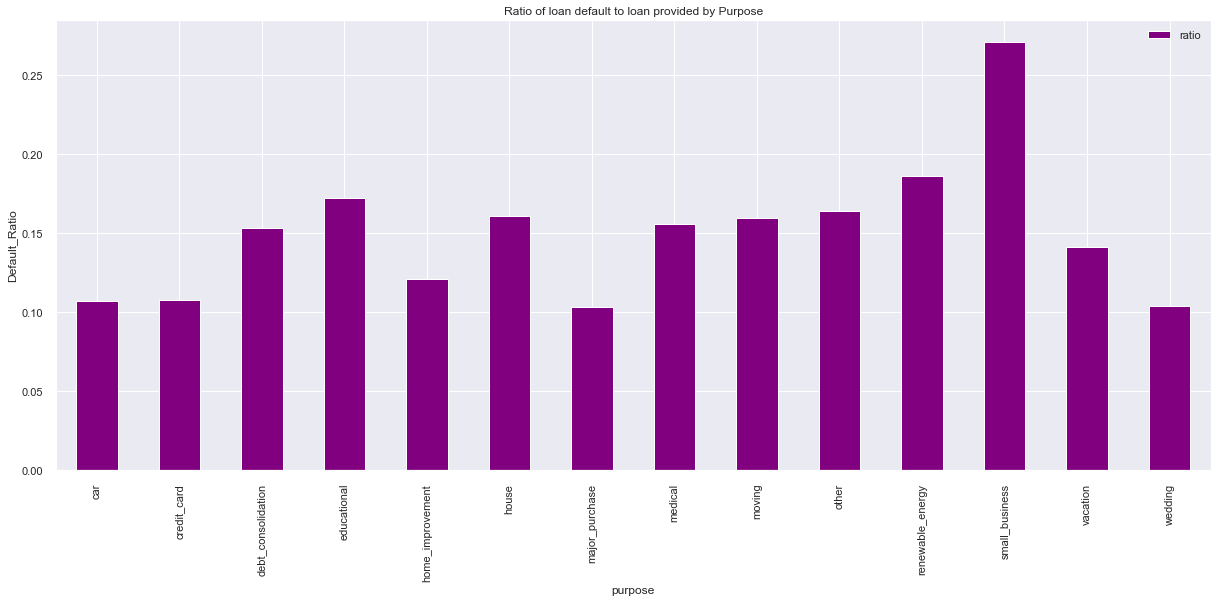

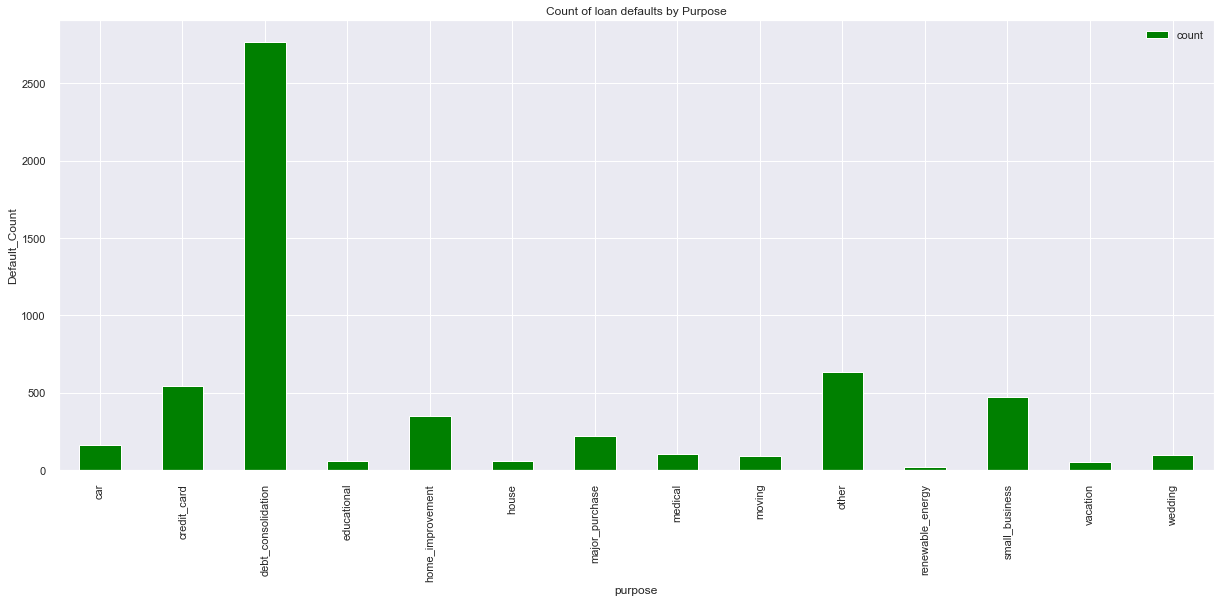

In [515]:
gp1 = loan[loan.status == 1].groupby(['purpose'])['purpose'].count().rename('count').reset_index()
gp0 = loan[loan.status == 0].groupby(['purpose'])['purpose'].count().rename('count').reset_index()

merged = pd.merge(gp1,gp0,on=['purpose'])
merged['ratio'] = merged['count_x']/(merged['count_x']+merged['count_y'])
merged = merged[['purpose','ratio']]

ax = merged.plot(kind='bar',x='purpose',y='ratio',color='purple')
plt.title('Ratio of loan default to loan provided by Purpose')
plt.ylabel("Default_Ratio")
ax = gp1.plot(kind='bar',x='purpose',y='count',color='green')
plt.title('Count of loan defaults by Purpose')
plt.ylabel("Default_Count")

Text(0.5, 1.0, 'Max money defaulted of the loans are on debt_conolidations')

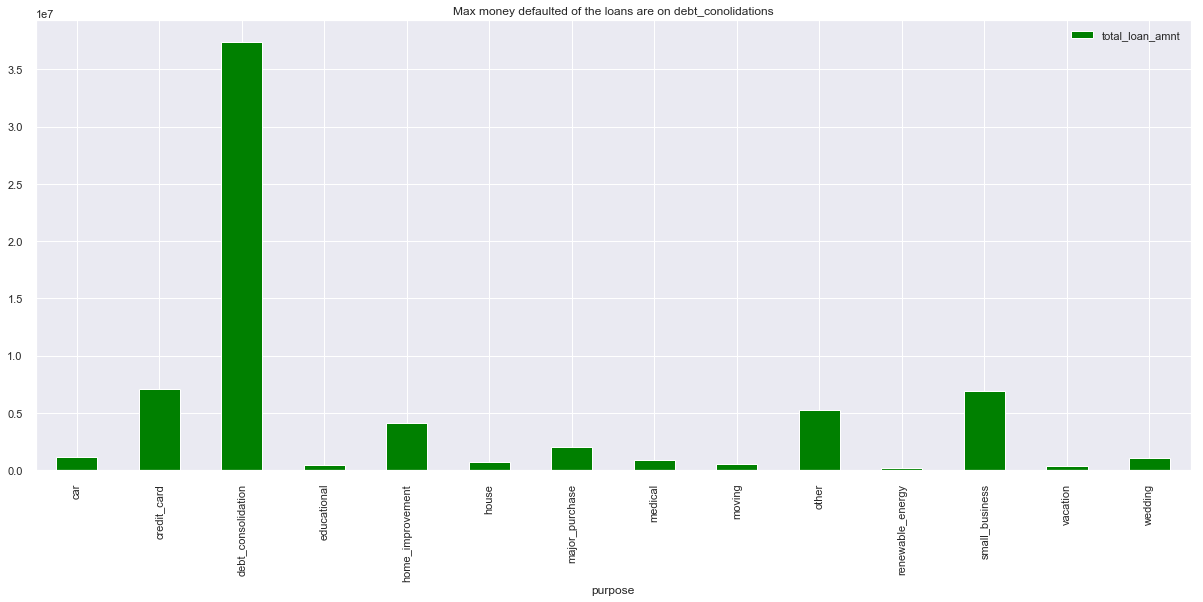

In [516]:
df = loan[loan.status == 1].groupby('purpose')['loan_amnt'].sum().rename('total_loan_amnt').reset_index('purpose')
df.plot(kind='bar',x='purpose',y='total_loan_amnt',color='green')
plt.title('Max money defaulted of the loans are on debt_conolidations')

In [517]:
print(categoricals)
print(loan.columns)

{'loan_status', 'last_pymnt_d', 'zip_code', 'addr_state', 'earliest_cr_line', 'home_ownership', 'issue_d', 'verification_status', 'emp_length', 'desc', 'grade', 'purpose', 'sub_grade', 'url', 'last_credit_pull_d', 'title', 'emp_title'}
Index(['loan_status', 'last_pymnt_d', 'zip_code', 'addr_state',
       'earliest_cr_line', 'home_ownership', 'issue_d', 'verification_status',
       'emp_length', 'desc', 'grade', 'purpose', 'sub_grade', 'url',
       'last_credit_pull_d', 'title', 'emp_title', 'loan_amnt', 'funded_amnt',
       'inq_last_6mths', 'pub_rec', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'status', 'term_months',
       'revol_util_percentage', 'int_rate_modified'],
      dtype='object')


   verification_status sub_grade     ratio
7         Not Verified        G3  0.750000
4         Not Verified        F5  0.692308
19     Source Verified        G5  0.500000
6         Not Verified        G2  0.500000
24            Verified        F5  0.477612
17     Source Verified        G3  0.444444
16     Source Verified        G2  0.437500
13     Source Verified        F4  0.421053
15     Source Verified        G1  0.413793
14     Source Verified        F5  0.393939
12     Source Verified        F3  0.387755
23            Verified        F4  0.376471
8         Not Verified        G4  0.375000
27            Verified        G3  0.375000
11     Source Verified        F2  0.349206
20            Verified        F1  0.341772
9         Not Verified        G5  0.333333
26            Verified        G2  0.320755
29            Verified        G5  0.312500
21            Verified        F2  0.300000


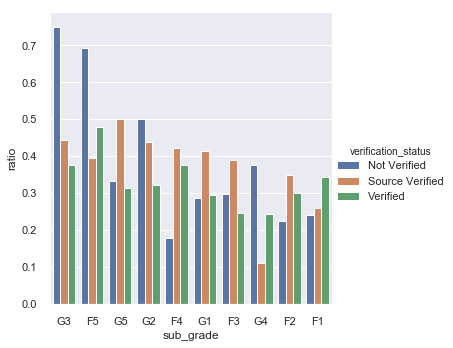

In [518]:
gp1 = loan[(loan.status == 1) & ((loan.grade == 'G') | (loan.grade == 'F'))].groupby(['verification_status','sub_grade'])['sub_grade'].count().rename('count').reset_index()
gp0 = loan[(loan.status == 0) & ((loan.grade == 'G') | (loan.grade == 'F'))].groupby(['verification_status','sub_grade'])['sub_grade'].count().rename('count').reset_index()

merged = pd.merge(gp1,gp0,on=['verification_status','sub_grade'])
merged['ratio'] = merged['count_x']/(merged['count_y']+merged['count_x'])
merged = merged[['verification_status','sub_grade','ratio','count_x','count_y']].sort_values(by='ratio',ascending=False)
#print(merged.head(12))
#merged.plot.bar(x='home_ownership')
print(merged[['verification_status','sub_grade','ratio']].head(20))
sns.catplot(x='sub_grade', y="ratio", hue="verification_status",
           kind="bar", data=merged)
#plt.title('36 months period has more defaults and purpose education has minimum default')

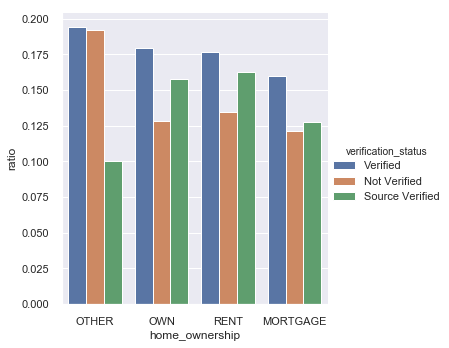

In [519]:
gp1 = loan[loan.status == 1].groupby(['verification_status','home_ownership'])['home_ownership'].count().rename('count').reset_index()
gp0 = loan[loan.status == 0].groupby(['verification_status','home_ownership'])['home_ownership'].count().rename('count').reset_index()

merged = pd.merge(gp1,gp0,on=['verification_status','home_ownership'])
merged['ratio'] = merged['count_x']/(merged['count_y']+merged['count_x'])
merged = merged[['verification_status','home_ownership','ratio','count_x','count_y']].sort_values(by='ratio',ascending=False)
#print(merged.head(12))
#merged.plot.bar(x='home_ownership')
sns.catplot(x='home_ownership', y="ratio", hue="verification_status",
           kind="bar", data=merged)
#plt.title('36 months period has more defaults and purpose education has minimum default')

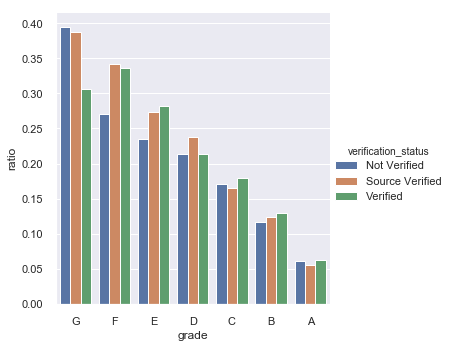

In [521]:
gp1 = loan[loan.status == 1].groupby(['verification_status','grade'])['grade'].count().rename('count').reset_index()
gp0 = loan[loan.status == 0].groupby(['verification_status','grade'])['grade'].count().rename('count').reset_index()

merged = pd.merge(gp1,gp0,on=['verification_status','grade'])
merged['ratio'] = merged['count_x']/(merged['count_y']+merged['count_x'])
merged = merged[['verification_status','grade','ratio','count_x','count_y']].sort_values(by='ratio',ascending=False)
#print(merged.head(12))
#merged.plot.bar(x='home_ownership')
sns.catplot(x='grade', y="ratio", hue="verification_status",
           kind="bar", data=merged)
#plt.title('36 months period has more defaults and purpose education has minimum default')